In [21]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import gensim
import nltk                           
import re   
import string
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from pymystem3 import Mystem
import ru_core_news_md
from gensim import parsing  
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter
import numpy as np
import scipy.stats as sts



# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [22]:
import clickhouse_connect

client = clickhouse_connect.get_client(host='81.200.148.178',
                                       username='champs', password='champs123')

In [23]:
from clickhouse_driver import Client

client_write = Client(client)

In [24]:
result = client.query('SELECT * FROM ymaps_shops')
df_shops = pd.DataFrame(result.result_rows)

In [25]:
df_shops

,0,1,2,3,4,5,6,7,8,9,10
0,1001360104,Перекресток,"[37.585667, 55.852607]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 1598.0, 'ratingValue': 4.40000...","ежедневно, 08:00–23:00","[{'id': 'station__9858799', 'name': 'Владыкино...","[{'id': 'stop__9647131', 'name': 'Алтуфьевское...","{'id': '6002404', 'name': 'Супермаркет Перекрё...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044705', 'text': 'Выбор товаров',..."
1,1001697690,Дикси,"[30.357889, 59.946321]","{'country': 'Россия', 'locality': 'Санкт-Петер...","{'ratingCount': 798.0, 'ratingValue': 3.900000...","ежедневно, круглосуточно","[{'id': 'station__9805917', 'name': 'Чернышевс...","[{'id': 'stop__10073304', 'name': 'Проспект Че...","{'id': '6003375', 'name': 'Дикси', 'quantityIn...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044050', 'text': 'Персонал', 'cou..."
2,1002469537,О'кей,"[30.622659, 59.739226]","{'country': 'Россия', 'area': 'Колпинский райо...","{'ratingCount': 8340.0, 'ratingValue': 4.90000...","ежедневно, 09:00–23:00",[],"[{'id': 'stop__10071423', 'name': 'Октябрьская...","{'id': '439598482', 'name': 'О'КЕЙ, гипермарке...","[{'id': 'payment_by_credit_card', 'name': 'опл...","[{'id': '3502044705', 'text': 'Выбор товаров',..."
3,1005579468,Перекрёсток,"[37.659366, 55.756499]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 2369.0, 'ratingValue': 4.30000...","ежедневно, круглосуточно","[{'id': 'station__9858944', 'name': 'Чкаловска...","[{'id': 'stop__9649588', 'name': 'Курский вокз...","{'id': '6002404', 'name': 'Супермаркет Перекрё...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044705', 'text': 'Выбор товаров',..."
4,1006026708,Усачёвский рынок,"[37.567781, 55.727567]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 29234.0, 'ratingValue': 5.0, '...","пн-чт 08:00–22:00; пт,сб 08:00–23:00; вс 08:00...","[{'id': 'station__9858909', 'name': 'Спортивна...","[{'id': 'stop__9644286', 'name': 'Абрикосовски...",{},"[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502043738', 'text': 'Еда', 'count': ..."
...,...,...,...,...,...,...,...,...,...,...,...
1281,243229261893,Ашан,"[37.637749, 55.705452]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 1169.0, 'ratingValue': 4.80000...","ежедневно, 08:00–22:00","[{'id': 'station__9858926', 'name': 'Тульская'...","[{'id': 'stop__9648777', 'name': 'Автозаводски...","{'id': '6003038', 'name': 'Ашан Гипермаркет', ...","[{'id': 'media_order_tmpl', 'name': '', 'value...","[{'id': '3502044705', 'text': 'Выбор товаров',..."
1282,243326420222,Пятёрочка,"[37.457576, 55.783307]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 1682.0, 'ratingValue': 4.09999...","ежедневно, 08:00–23:00","[{'id': '4237676049', 'name': 'Народное Ополче...","[{'id': 'stop__9640607', 'name': 'Улица Маршал...","{'id': '6003206', 'name': 'Пятёрочка', 'quanti...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044050', 'text': 'Персонал', 'cou..."
1283,244062981984,Пятёрочка,"[37.674435, 55.72606]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 1162.0, 'ratingValue': 4.19999...","ежедневно, 08:00–23:00","[{'id': 'station__9858802', 'name': 'Волгоград...","[{'id': 'stop__9644418', 'name': 'Улица Мельни...","{'id': '6003206', 'name': 'Пятёрочка', 'quanti...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044050', 'text': 'Персонал', 'cou..."
1284,245291451678,Перекрёсток,"[37.406818, 55.80693]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 2988.0, 'ratingValue': 4.40000...","ежедневно, 08:00–00:00","[{'id': 'station__9858912', 'name': 'Строгино'...","[{'id': 'stop__9640698', 'name': 'Музыкальная ...","{'id': '6002404', 'name': 'Супермаркет Перекрё...","[{'id': 'food_product_delivery', 'name': 'дост...","[{'id': '3502044705', 'text': 'Выбор товаров',..."


In [26]:
def column_to_columns(df: pd.DataFrame, col: str) -> pd.DataFrame:
    data = pd.json_normalize(df[col])
    keys = [f'{col}_{key}' for key in data.columns]
    df[keys] = data
    return df
    
def columns_to_unwrap(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    for col in cols:
        df = column_to_columns(df, col)
    return df

In [27]:
df_shops.columns = ['id', 'title', 'coordinates', 'address', 'rating', 'working_hours', 'metro', 'stops', 
              'chain', 'features', 'aspects']

In [28]:
cols_to_unwrap = ['address', 'rating', 'chain']
df_shops = columns_to_unwrap(df_shops, cols_to_unwrap)

In [29]:
df_shops.head()

,id,title,coordinates,address,rating,working_hours,metro,stops,chain,features,...,address_locality,address_street,address_house,address_area,rating_ratingCount,rating_ratingValue,rating_reviewCount,chain_id,chain_name,chain_quantityInCity
0,1001360104,Перекресток,"[37.585667, 55.852607]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 1598.0, 'ratingValue': 4.40000...","ежедневно, 08:00–23:00","[{'id': 'station__9858799', 'name': 'Владыкино...","[{'id': 'stop__9647131', 'name': 'Алтуфьевское...","{'id': '6002404', 'name': 'Супермаркет Перекрё...","[{'id': 'food_product_delivery', 'name': 'дост...",...,Москва,Алтуфьевское шоссе,8,NaN,1598.0,4.4,504.0,6002404,Супермаркет Перекрёсток,302
1,1001697690,Дикси,"[30.357889, 59.946321]","{'country': 'Россия', 'locality': 'Санкт-Петер...","{'ratingCount': 798.0, 'ratingValue': 3.900000...","ежедневно, круглосуточно","[{'id': 'station__9805917', 'name': 'Чернышевс...","[{'id': 'stop__10073304', 'name': 'Проспект Че...","{'id': '6003375', 'name': 'Дикси', 'quantityIn...","[{'id': 'food_product_delivery', 'name': 'дост...",...,Санкт-Петербург,улица Чайковского,55,NaN,798.0,3.9,271.0,6003375,Дикси,294
2,1002469537,О'кей,"[30.622659, 59.739226]","{'country': 'Россия', 'area': 'Колпинский райо...","{'ratingCount': 8340.0, 'ratingValue': 4.90000...","ежедневно, 09:00–23:00",[],"[{'id': 'stop__10071423', 'name': 'Октябрьская...","{'id': '439598482', 'name': 'О'КЕЙ, гипермарке...","[{'id': 'payment_by_credit_card', 'name': 'опл...",...,Колпино,Октябрьская улица,8,Колпинский район,8340.0,4.9,1746.0,439598482,"О'КЕЙ, гипермаркеты",1
3,1005579468,Перекрёсток,"[37.659366, 55.756499]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 2369.0, 'ratingValue': 4.30000...","ежедневно, круглосуточно","[{'id': 'station__9858944', 'name': 'Чкаловска...","[{'id': 'stop__9649588', 'name': 'Курский вокз...","{'id': '6002404', 'name': 'Супермаркет Перекрё...","[{'id': 'food_product_delivery', 'name': 'дост...",...,Москва,улица Земляной Вал,33,NaN,2369.0,4.3,596.0,6002404,Супермаркет Перекрёсток,302
4,1006026708,Усачёвский рынок,"[37.567781, 55.727567]","{'country': 'Россия', 'locality': 'Москва', 's...","{'ratingCount': 29234.0, 'ratingValue': 5.0, '...","пн-чт 08:00–22:00; пт,сб 08:00–23:00; вс 08:00...","[{'id': 'station__9858909', 'name': 'Спортивна...","[{'id': 'stop__9644286', 'name': 'Абрикосовски...",{},"[{'id': 'food_product_delivery', 'name': 'дост...",...,Москва,Усачёва улица,26,NaN,29234.0,5.0,8402.0,NaN,NaN,NaN


In [30]:
# 6, 7 подумать

In [31]:
result = client.query('SELECT * FROM ymaps_reviews')
df_reviews = pd.DataFrame(result.result_rows)
df_reviews.shape

(458968, 10)

In [32]:
df_reviews.columns = ['review_id', 'business_id', 'user_id', 'user_level',
                     'time', 'rating', 'likes', 'dislikes', 'language', 'text']

# Preprocessing

In [34]:
nlp = ru_core_news_md.load()
mystem = Mystem() 
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('russian'))
STOPWORDS.remove('не')
STOPWORDS.remove('нет')
STOPWORDS.remove('хорошо')
STOPWORDS.add("другой")
STOPWORDS.add("который")
STOPWORDS.add("такой")
STOPWORDS.add("данный")
STOPWORDS.add("свой")

PUNCT_TO_REMOVE = string.punctuation + '\n\t' + '…' + '\n\t' + '”' + '“' + '’' + '' + '«' + '»'

def lemmatize_words(text, lemmatizer):
    try: 
        return " ".join([lemmatizer.lemmatize(word)[0] for word in text.split()])
    except:
        print(text)
        
def lemmatize_words_spacy(text, model):
    document = model(text)
    return " ".join([token.lemma_ for token in document])

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_urls(text):
    return re.sub(r"http\S+", "", text)

def remove_short(text):
    return " ".join([word for word in str(text).split() if len(word)>3])

In [37]:
def create_ngrams(data_words, min_count=5, threshold=100):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=threshold)  

    # Get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

def make_bigrams(text, bigram_mod):
#     text = text.split()
    return " ".join(bigram_mod[text.split()])

def make_trigrams(text, bigram_mod, trigram_mod):
    return " ".join(trigram_mod[bigram_mod[text.split()]])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def not_concat(text, model):
    document = model(text)
    tokens = text.split()
    for i, token in enumerate(tokens[:-1]):
        if (document[i].pos_ == 'PART') and (document[i+1].pos_ == 'ADJ' or document[i+1].pos_ == 'ADV' or 
                                 document[i+1].pos_ == 'VERB'):
            tokens[i] = f'{tokens[i]}_{tokens[i+1]}'
            tokens[i+1] = ''
        else:
            tokens[i] = tokens[i]
            tokens[i+1] = tokens[i+1]
            
    return ' '.join(tokens)

In [38]:
%%time
lemmatizer = Mystem() 
text_col = 'text'
text_prep_col = 'text_preproc'
text_prep_ngams_col = 'text_preproc_ngams'
text_prep_ngams_not_col = 'text_prep_ngams_not'
df_reviews[text_prep_col] = df_reviews[text_col].values

df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(str)
df_reviews[text_prep_col] = df_reviews[text_prep_col].str.lower()
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(remove_urls)
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(remove_punctuation)
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(remove_numbers)
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(remove_stopwords)
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(lemmatize_words, args=(lemmatizer, ))

data_lists = df_reviews[text_prep_col].values.tolist()
data_words = list(sent_to_words(data_lists))
bigram_mod, trigram_mod = create_ngrams(data_words, min_count=4, threshold=1) 

df_reviews[text_prep_ngams_col] = df_reviews[text_prep_col].apply(make_bigrams, args=(bigram_mod,)) 
df_reviews[text_prep_ngams_col] = df_reviews[text_prep_ngams_col].apply(make_trigrams, args=(bigram_mod, trigram_mod,))

# df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(lemmatize_words)
# df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(lemmatize_words)

# df_reviews[text_prep_ngams_not_col] = df_reviews[text_prep_ngams_col].apply(not_concat, args=(nlp, ))
df_reviews[text_prep_col] = df_reviews[text_prep_col].apply(remove_short)
df_reviews[text_prep_ngams_col] = df_reviews[text_prep_ngams_col].apply(remove_short)

CPU times: user 2min 11s, sys: 19.5 s, total: 2min 31s
Wall time: 5min 25s


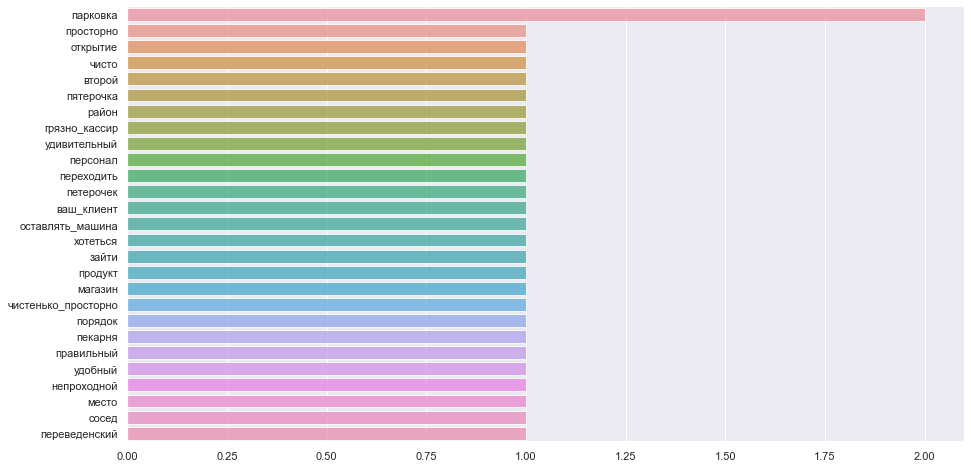

In [456]:
# find the most common words in the data
top_30 = Counter(" ".join(df_reviews.loc[df_reviews.business_id==2848891128, text_prep_ngams_col]).split()).most_common(30)
top_30 = np.array(top_30)

x = [int(x) for x in top_30[:, 1]]
y = top_30[:, 0]
plt.figure(figsize=(15,8))
sns.barplot(x, y, alpha=0.8)
plt.show()

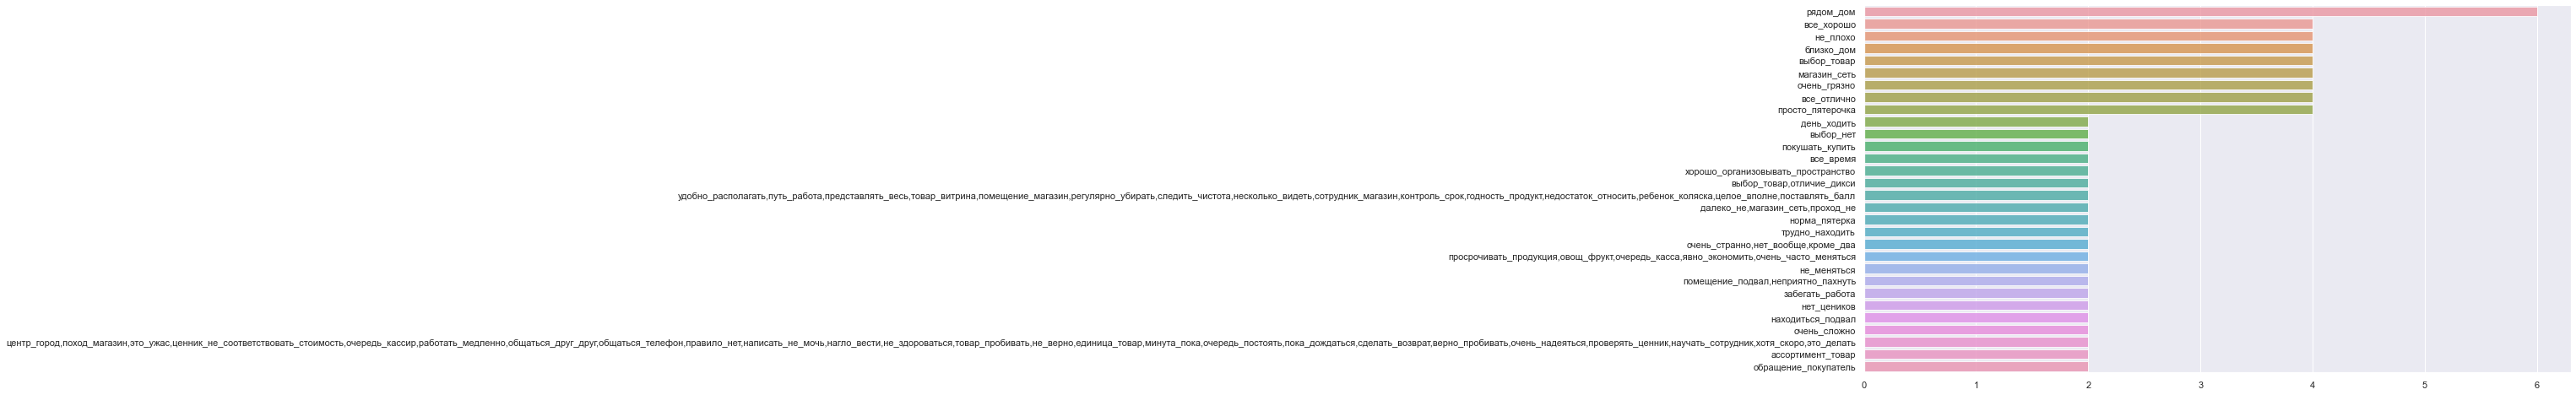

In [135]:
# find the most common ngrams in the data
idd = 93682651498
f = lambda s : ",".join([i for i in s if '_' in i])
s = ' '.join(df_reviews.loc[df_reviews.business_id==idd, text_prep_ngams_col].apply(str.split).apply(f))

top_30 = Counter(s.split()).most_common(30)
top_30 = np.array(top_30)

x = [int(x) for x in top_30[:, 1]]
y = top_30[:, 0]
plt.figure(figsize=(15,8))
sns.barplot(x, y, alpha=0.8)
plt.show()

# Find negative dynamic in ratings

In [116]:
from datetime import date

def time_delta(date):
    today = pd.to_datetime(date.today(),utc=True)
    return today - date

def find_previous_rating(df, time_col, rating_col, date, days):
    df_tmp = df.copy()
    df_tmp['time_delta'] = date - df_tmp[time_col]
    df_tmp = df_tmp[(df_tmp['time_delta'].dt.days <= days) & (df_tmp[time_col] < date)]
    mean_rating = df_tmp[rating_col].mean()
    std_rating = df_tmp[rating_col].std()
    
    return mean_rating, std_rating

In [126]:
%%time
df_rating_stats = pd.DataFrame(columns=['id', 'time_month', 'curr_rating', 'curr_rating_count', 
                                        'previous_rating', 'rating_diff', 'is_hit'])
df_reviews['time_month'] = df_reviews.time.dt.to_period('M')
dates = df_reviews['time_month'].unique()

titles = ['Перекрёсток', 'Пятёрочка', 'Супермаркет Перекрёсток', 'Перекресток']
shop_ids = df_shops[df_shops.title.isin(titles)].id.unique()
days = 90

time_col = 'time'
rating_col = 'rating'

counter = 0

for shop_id in shop_ids:
    df_tmp = df_reviews[df_reviews.business_id == shop_id]
    for date in dates:
        counter+=1
        date_tmp = pd.to_datetime(date.strftime('%Y-%m-01'),utc=True)
        mean = df_tmp.loc[df_tmp['time_month'] == date, rating_col].mean()
        count = df_tmp.loc[df_tmp['time_month'] == date, rating_col].count()
        mean_3m, std_3m = find_previous_rating(df_tmp, time_col, rating_col, date_tmp, days)
        diff = (mean - mean_3m) / mean_3m if mean_3m!=0 else 0
        df_rating_stats.loc[counter, :] = shop_id, date_tmp, mean, count, mean_3m, diff, diff<=-0.2

CPU times: user 1min 54s, sys: 1.74 s, total: 1min 56s
Wall time: 1min 58s


In [119]:
df_rating_stats.time_month = df_rating_stats.time_month.apply(pd.to_datetime)

In [139]:
df_rating_stats[(df_rating_stats.is_hit==True)].groupby('time_month').count()

,id,curr_rating,curr_rating_count,previous_rating,rating_diff,is_hit
time_month,,,,,,
2018-01-01 00:00:00+00:00,2,2,2,2,2,2
2018-02-01 00:00:00+00:00,2,2,2,2,2,2
2018-03-01 00:00:00+00:00,7,7,7,7,7,7
2018-04-01 00:00:00+00:00,19,19,19,19,19,19
2018-05-01 00:00:00+00:00,29,29,29,29,29,29
...,...,...,...,...,...,...
2023-05-01 00:00:00+00:00,25,25,25,25,25,25
2023-06-01 00:00:00+00:00,24,24,24,24,24,24
2023-07-01 00:00:00+00:00,35,35,35,35,35,35


In [144]:
client.command('''
    CREATE TABLE rating_stats (
        id Int64,
        time_month Timestamp,
        curr_rating Float32,
        curr_rating_count Int64,
        previous_rating Float32,
        rating_diff Float32,
        is_hit Bool
    ) ENGINE = Memory
''')


client.insert('rating_stats', df_rating_stats, column_names=['id', 'time_month', 'curr_rating', 'curr_rating_count',
       'previous_rating', 'rating_diff', 'is_hit'])

In [62]:
result = client.query('SELECT * FROM rating_stats')
df_stats = pd.DataFrame(result.result_rows)

In [67]:
df_stats[df_stats[6]==True]

,0,1,2,3,4,5,6
9,1005579468,2022-11-01 00:00:00+00:00,3.090909,11,3.935484,-0.214605,True
21,1005579468,2021-05-01 00:00:00+00:00,3.529412,17,4.500000,-0.215686,True
27,1005579468,2023-08-01 00:00:00+00:00,3.411765,17,4.288889,-0.204511,True
48,1005579468,2019-08-01 00:00:00+00:00,2.600000,5,4.470588,-0.418421,True
146,1006297135,2022-09-01 00:00:00+00:00,3.000000,4,4.384615,-0.315789,True
...,...,...,...,...,...,...,...
35838,478315806,2021-03-01 00:00:00+00:00,3.500000,8,4.375000,-0.200000,True
35857,478315806,2019-01-01 00:00:00+00:00,4.000000,1,5.000000,-0.200000,True
35872,478315806,2020-10-01 00:00:00+00:00,3.200000,10,4.312500,-0.257971,True
35873,478315806,2019-02-01 00:00:00+00:00,3.666667,3,4.800000,-0.236111,True


# Find ADJ+NOUN and ADV+VERB pairs

In [242]:
def find_noun_adj_pairs(text, model):
    document = model(text)
    pairs = []
    for i, token in enumerate(document[:-1]):
        pairs_tmp = []
        tok1 = token
        tok2 = document[i+1]
        if (tok1.pos_ == 'ADJ' or tok1.pos_ == 'ADV') and (tok2.pos_ == 'NOUN' or tok2.pos_ == 'VERB'):
            pairs.append([tok1, tok2])
        if (tok2.pos_ == 'ADJ' or tok2.pos_ == 'ADV') and (tok1.pos_ == 'NOUN' or tok1.pos_ == 'VERB'):
            pairs.append([tok1, tok2])
    return pairs
text = df_reviews.text[6]
print(text)
find_noun_adj_pairs(text, nlp)

Очень сложно найти продукты после ремонта


[[сложно, найти]]

In [225]:
def not_concat(text):
    tokens = text.split()
    for i, token in enumerate(tokens):
        if (token == 'не' or token == 'нет') and len(tokens)>i:
            tokens[i] = f'{token}_{tokens[i+1]}'
            tokens[i+1] = ''
    return ' '.join(tokens)

In [226]:
text_prep_not_col = 'text_prep_not'
df_reviews[text_prep_pairs_col] = find_noun_adj_pairs(text, nlp)

[[хотя_рано, отличный],
 [отличный, магазин],
 [персонал, вежливый],
 [вежливый, директор]]

In [ ]:
text_prep_pairs_col = 'text_prep_pairs'
df_reviews[text_prep_pairs_col] = df_reviews[text_prep_col].apply(find_noun_adj_pairs, args = (nlp,))

# Find Aspects by keywords

In [538]:
ASPECTS = {'variety': ['выбор', 'ассортимент', 'асортимент', 'выбрать', 'выбирать', ], 
'staff' : ['персонал', 'работник', 'директор', 'касcир', 'касир','обслуживание', 'продавец', 'сотрудник', 
           'управляющий', 'администратор'],
'price_tag': ['ценник', 'цена', 'цены', 'дорогой', 'дешевый'],
'cleanliness': ['грязный', 'грязно', 'запах', 'воняет', 'пахнет', 'вонь', 'немытый', 'чисто', 'аккуратно','аккуратный', 'чистый'],
'line': ['очереди', 'очередь', 'долго','долгий', 'обслуживание', 'ждать', 'быстро', 'быстрый', 'стоять'],
'products_quality': ['срок', 'сроки', 'свежий', 'свежие', 'испорченный', 'испорченый', 'испорченный', 'тухлый', 
                     'гнилой', 'просрочка', 'просроченый', 'продукция', 'товар', 'гниль'],
'security': ['бомж', 'алкаш', 'охранник', 'пьяный', 'охрана'],
'layout': ['найти', 'искать', 'полки', 'полка', 'пустой', 'выкладка'],
'delivery': ['доставка', 'курьер', 'заказ']}

def find_aspects(text):
#     tokens = text.split()
    aspects_text = {}
    for key, words in ASPECTS.items():
        for word in words:
            if word in text:
                aspects_text[key] = True
                break
            else:
                aspects_text[key] = False
    return aspects_text

In [539]:
text_aspects_col = 'text_aspects'
df_reviews[text_aspects_col ] = df_reviews[text_prep_col].apply(find_aspects)

In [540]:
df_reviews[text_aspects_col ] 

0         {'variety': False, 'staff': False, 'price_tag'...
1         {'variety': True, 'staff': False, 'price_tag':...
2         {'variety': False, 'staff': True, 'price_tag':...
3         {'variety': False, 'staff': False, 'price_tag'...
4         {'variety': True, 'staff': False, 'price_tag':...
                                ...                        
458963    {'variety': True, 'staff': False, 'price_tag':...
458964    {'variety': True, 'staff': True, 'price_tag': ...
458965    {'variety': False, 'staff': False, 'price_tag'...
458966    {'variety': False, 'staff': False, 'price_tag'...
458967    {'variety': False, 'staff': False, 'price_tag'...
Name: text_aspects, Length: 458968, dtype: object

In [541]:
cols_to_unwrap = [text_aspects_col]
df_reviews = columns_to_unwrap(df_reviews, cols_to_unwrap)

In [543]:
df_reviews.columns

Index(['review_id', 'business_id', 'user_id', 'user_level', 'time', 'rating',
       'likes', 'dislikes', 'language', 'text', 'text_preproc',
       'text_preproc_ngams', 'text_aspects', 'text_aspects_variety',
       'text_aspects_staff', 'text_aspects_price_tag',
       'text_aspects_cleanliness', 'text_aspects_line',
       'text_aspects_products_quality', 'text_aspects_security',
       'text_aspects_layout', 'text_aspects_delivery'],
      dtype='object')

In [548]:
tb_name_aspects = 'reviews_aspects'
aspects_cols = ['review_id', 'business_id', 'time', 'rating',
       'text_aspects_variety',
       'text_aspects_staff', 'text_aspects_price_tag',
       'text_aspects_cleanliness', 'text_aspects_line',
       'text_aspects_products_quality', 'text_aspects_security',
       'text_aspects_layout', 'text_aspects_delivery']

client.command(f'''
    CREATE TABLE {tb_name_aspects} (
        review_id String,
        business_id Int64,
        time Timestamp,
        rating Float32,
        text_aspects_variety Bool,
        text_aspects_staff Bool,
        text_aspects_price_tag Bool,
        text_aspects_cleanliness Bool,
        text_aspects_line Bool,
        text_aspects_products_quality Bool,
        text_aspects_security Bool,
        text_aspects_layout Bool,
        text_aspects_delivery Bool
        
    ) ENGINE = Memory
''')


client.insert(tb_name_aspects, df_reviews[aspects_cols], column_names=aspects_cols)

In [549]:
result = client.query(f'SELECT * FROM {tb_name_aspects}')
df_aspects = pd.DataFrame(result.result_rows)
df_aspects

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,---lrMICWU-AyoDa218IhvsHgkBWwk,1016276571,2023-03-19 15:10:39+00:00,5.0,False,False,False,False,False,False,False,False,False
1,---xwwd5MRtVxSkUda2NfAWuVEGnra,1244671383,2019-10-15 22:17:10+00:00,5.0,True,False,True,False,False,False,False,False,False
2,---zS1nETIPXk4bx0ZDHjCpaMf9KDH,49508116938,2020-04-24 08:20:36+00:00,1.0,False,True,True,True,False,False,False,False,False
3,--0iZ2JReyvP44K4Sml0TI3C0i9Rw-Eo,1107673873,2021-12-10 08:46:35+00:00,5.0,False,False,False,False,False,False,False,False,False
4,--14gymVtYAH3QL5Xx0YgZVS91hLQj,1296991140,2019-12-28 10:45:11+00:00,5.0,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458963,zu8cD9KKVK75eSYcS8nY8TTsvKAcmJa,1096396166,2022-06-03 16:36:04+00:00,5.0,True,False,False,False,False,False,False,False,False
458964,zuCVjOEkzj-q-VNo0KajTG-s8ot1-Am,1158436596,2021-02-27 03:24:59+00:00,3.0,True,True,False,False,False,False,False,False,False
458965,zwpm-q07OVZSr3CAG_nVVCJCrL3suMY4d,236748736583,2022-09-13 05:56:25+00:00,5.0,False,False,False,False,False,False,False,False,False
458966,zy3uY9aKeu9VTTol2ntE2CatK-wAWDCc,1096396166,2023-03-20 08:00:42+00:00,5.0,False,False,False,False,False,False,False,False,False


# Find keywords

In [81]:
# !pip install nlp-rake

In [68]:
from nlp_rake import Rake
import nltk
from nltk.corpus import stopwords
# nltk.download ("stopwords")
stops = list(set(stopwords.words("russian")))
text = '.'.join(df_reviews[df_reviews.business_id==1005579468].text)
rake = Rake (stopwords = stops, max_words = 4)
rake.apply(text) [:20]

[('хамон видать кто-то ел', 16.0),
 ('исключением одной крупнокалиберной мадмуазель', 16.0),
 ('мониторы вечно ждут подтверждения', 16.0),
 ('возможность начать ваше утро', 16.0),
 ('холодильники простую питьевую воду', 16.0),
 ('наблюдается явная нехватка продавцов-кассиров', 16.0),
 ('сканирование стало намного проще', 15.5),
 ('самый свежий- двухдневной давности', 15.285714285714285),
 ('совершенно непонятным причинам стоит', 15.25),
 ('попросил объяснить своё дейсивие', 15.0),
 ('готовых блюд пробовали многое', 15.0),
 ('последние пару месяцев испортили', 15.0),
 ('сначала вежливо попросила отойти', 15.0),
 ('самым разбудив местных охранников', 15.0),
 ('пренибрежительное поведение сотрудника оставляет', 15.0),
 ('пожалуйста пересмотрите норму соли', 14.833333333333334),
 ('хотите можете подождать человека', 14.833333333333334),
 ('показал приложения перекрестка яркость', 14.75),
 ('сыр сулугуни фирмы умалат', 14.666666666666666),
 ('являюсь её постоянным покупателем', 14.666666666

In [70]:
# !pip install yake
import yake

extractor = yake.KeywordExtractor (

    lan = "ru",     # язык
    n = 4,          # максимальное количество слов в фразе
    dedupLim = 0.3, # порог похожести слов
    top = 20        # количество ключевых слов
)

extractor.extract_keywords(text)

[('магазин может и неплохой', -4.8610713443122275),
 ('персонал не везде хороший', -0.48225663039299294),
 ('хороший магазин', 0.0006523906921420972),
 ('большой выбор', 0.0027959728849210716),
 ('ассортимент', 0.004767197086089721),
 ('хороший выбор продуктов.Выбор большой', 0.00637054392433476),
 ('Цены', 0.007386428688085782),
 ('выбор товаров', 0.008183962581382388),
 ('продуктов', 0.008535184585686589),
 ('отличный', 0.009398655056156464),
 ('свежие', 0.010928779950606198),
 ('Супермаркет', 0.012494580721932096),
 ('самообслуживания', 0.01391628408582451),
 ('Классический хороший перекрёсток', 0.014650671567454218),
 ('Удобно', 0.016610919918600826),
 ('чисто', 0.017452739033411824),
 ('очереди', 0.018997720932006818),
 ('купить', 0.023062574912260533),
 ('кассы', 0.024357150980885547),
 ('большой ассортимент товаров представлен', 0.026676115968379623)]

In [57]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 789.0 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=36cc8155ffd6e86d6db3a7dffe9cbfa0dbddfc3e6d5b8364b660194b532f58c1
  Stored in directory: /Users/elizaveta/Library/Caches/pip/wheels/fd/6a/dd/209eb19d5f2266b9cfd06827539bf70435b0ad5fe8244e52d3
Successfully built summa
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [58]:
from summa import keywords
text_clean = ""
# уберем стоп-слова
for i in text.split():
    if i not in stops:
        text_clean += i + " "
keywords.keywords (text_clean, language = "russian").split("\n")

['лента',
 'ленту',
 'лентах',
 'лентой',
 'магазинах',
 'магазинам',
 'магазины',
 'магазине',
 'магазином',
 'магазинов',
 'магазину',
 'магазин хороший',
 'товаров',
 'товара',
 'товары',
 'товарами',
 'товарах',
 'товаром',
 'больше',
 'большая',
 'больших',
 'большей',
 'большо',
 'большие',
 'большую',
 'большого',
 'большим',
 'большими',
 'большом',
 'другими лентами',
 'хорошая',
 'хорошим',
 'хорошего',
 'хорошими',
 'хорошее',
 'хорошему',
 'хорошей',
 'цены',
 'ценами',
 'цене',
 'ценах',
 'цену',
 'цен',
 'товаре чистая',
 'ленте система',
 'этим',
 'эта',
 'этой',
 'лент ассортименту отсутствию',
 'удобно',
 'удобнее',
 'удобных',
 'удобного',
 'большое спасибо сотрудникам магазина',
 'всё',
 'всей',
 'кассе удобное',
 'кассы',
 'кассам',
 'некоторым товарам',
 'ассортимент',
 'ассортимента',
 'утра большой',
 'парковка',
 'парковкой',
 'парковку',
 'парковки',
 'супер очень',
 'продуктов',
 'продуктами',
 'продукты',
 'продукт',
 'доставки ленты закупаются',
 'ценам сто'

In [71]:
!python -m nltk.downloader universal_tagset

/Users/elizaveta/opt/anaconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/elizaveta/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [76]:
# !python install git+https://github.com/boudinfl/pke.git

python: can't open file 'install': [Errno 2] No such file or directory


In [77]:
# # script.py
# import pke

# # initialize keyphrase extraction model, here TopicRank
# extractor = pke.unsupervised.TopicRank()

# # load the content of the document, here document is expected to be in raw
# # format (i.e. a simple text file) and preprocessing is carried out using spacy
# extractor.load_document(input=text, language='en')

# # keyphrase candidate selection, in the case of TopicRank: sequences of nouns
# # and adjectives (i.e. `(Noun|Adj)*`)
# extractor.candidate_selection()

# # candidate weighting, in the case of TopicRank: using a random walk algorithm
# extractor.candidate_weighting()

# # N-best selection, keyphrases contains the 10 highest scored candidates as
# # (keyphrase, score) tuples
# keyphrases = extractor.get_n_best(n=10)

In [78]:
!pip install keybert

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for transformers<5.0.0,>=4.6.0 from https://files.pythonhosted.org/packages/13/30/54b59e73400df3de506ad8630284e9fd63f4b94f735423d55fc342181037/transformers-4.33.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for huggingface-hub>=0.4.0 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [79]:
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(text)

In [80]:
keywords

[('съедобные', 0.4398),
 ('объемными', 0.4244),
 ('охраной', 0.4171),
 ('продукцией', 0.4054),
 ('администрация', 0.4007)]

# Topic modeling

## Train model

In [457]:
text_prep_ngams_col = 'text_preproc_ngams'

In [458]:
df_reviews_neg = df_reviews[df_reviews.rating<=3]

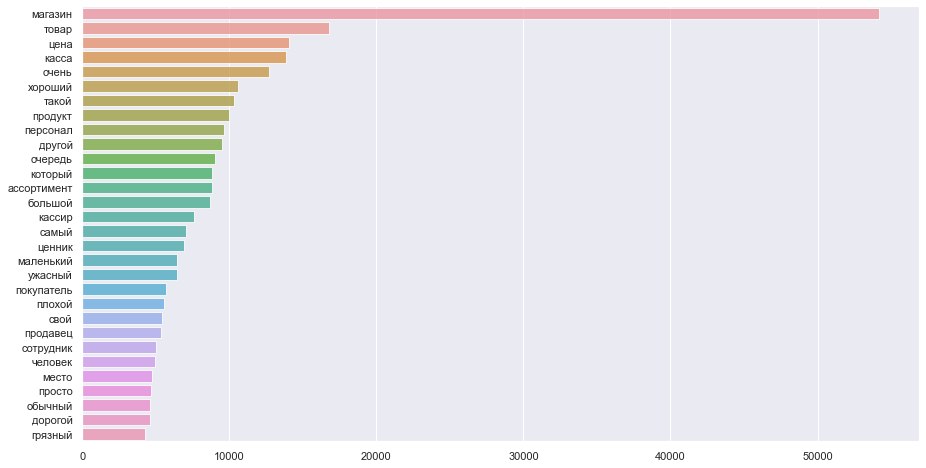

In [459]:
# find the most common words in the data
top_30 = Counter(" ".join(df_reviews_neg[text_prep_ngams_col]).split()).most_common(30)
top_30 = np.array(top_30)

x = [int(x) for x in top_30[:, 1]]
y = top_30[:, 0]
plt.figure(figsize=(15,8))
sns.barplot(x, y, alpha=0.8)
plt.show()

In [460]:
# Tokenize each sentence into a list of words
tokenizer = WordPunctTokenizer()
data_tok = []
for string in df_reviews_neg[text_prep_ngams_col]:
    data_tok.append([token for token in tokenizer.tokenize(string)])
data_tok[:2]

[['спрашивать_цена',
  'начели',
  'хомить',
  'говорять',
  'слепой',
  'чтоль',
  'видет',
  'лежать',
  'просырочонное',
  'продукт',
  'колбаса_торт',
  'один_плюс',
  'очень_чисто_уютно',
  'спосибо',
  'уборщица',
  'каторый',
  'хомить',
  'походить',
  'директорший',
  'зовуд',
  'юлия',
  'разбираться',
  'пожалуйста'],
 ['персонал_оставлять', 'желать', 'хороший']]

In [461]:
# Create dictionary, corpus and compute term documrnt frequency for Topic Modeling

id2word = corpora.Dictionary(data_tok)

In [462]:
id2word.filter_extremes(no_below=5,no_above=0.2,keep_n=None)
texts = data_tok

In [463]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])
print(id2word[0])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1)]]
видет


In [466]:
document_num = 1000
random = np.random.randint(1,len(df_reviews_neg))
bow_doc_x = corpus[random]

for i in range(len(bow_doc_x)):
    print(f'Word {bow_doc_x[i][0]} {id2word[bow_doc_x[i][0]]} appears {bow_doc_x[i][1]} times')

Word 109 продавец appears 1 times
Word 345 около appears 1 times
Word 426 пакет appears 1 times
Word 495 тухлый appears 1 times
Word 605 развес appears 1 times
Word 1097 ребро appears 1 times
Word 1173 душок appears 1 times
Word 1259 продавать appears 1 times
Word 2739 свежесть_продукт appears 1 times
Word 2883 впаривать appears 1 times
Word 2994 пока_не appears 1 times
Word 3245 не_думать appears 1 times
Word 5205 возвращаться_магазин appears 1 times
Word 5508 свиной appears 1 times
Word 13683 почувствовать_запах appears 1 times
Word 22613 иначе_мочь appears 1 times
Word 27042 поздно_проверять appears 1 times


In [467]:
%%time
# Build the LDA model with 10 topics per corpus
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=3,
                                       per_word_topics=True,
                                       workers=4)

CPU times: user 18.9 s, sys: 4.41 s, total: 23.3 s
Wall time: 29.8 s


In [468]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"отдел" + 0.011*"готовый" + 0.010*"хороший" + 0.010*"продукт" + '
  '0.010*"купить" + 0.008*"свежий" + 0.008*"просто" + 0.008*"мясо" + '
  '0.008*"тухлый" + 0.007*"мясной"'),
 (1,
  '0.036*"цена" + 0.035*"товар" + 0.023*"ценник" + 0.015*"дорогой" + '
  '0.011*"другой" + 0.007*"акция" + 0.007*"который" + 0.007*"ценник_не" + '
  '0.006*"быть" + 0.005*"не_соответствовать"'),
 (2,
  '0.016*"товар" + 0.014*"другой" + 0.014*"ашан" + 0.010*"цена" + '
  '0.007*"лента" + 0.007*"скидка" + 0.007*"последний" + 0.006*"приятный" + '
  '0.006*"время" + 0.006*"продукт"'),
 (3,
  '0.008*"такой" + 0.008*"тесный" + 0.007*"данный" + 0.006*"первый" + '
  '0.006*"зайти" + 0.006*"гипермаркет" + 0.005*"рынок" + 0.005*"горячий" + '
  '0.005*"который" + 0.005*"рыба"'),
 (4,
  '0.019*"очень" + 0.016*"грязный" + 0.016*"очередь" + 0.015*"грязно" + '
  '0.011*"персонал" + 0.011*"постоянный" + 0.011*"вечный" + 0.009*"цена" + '
  '0.009*"ужасный" + 0.009*"очередь_касса"'),
 (5,
  '0.040*"ассортимент" + 

In [469]:
#The above LDA model is built with 10 different topics where each topic is a combination of keywords and 
# each keyword contributes a certain importance to the topic.
print(lda_model.show_topics())
doc_lda = lda_model[corpus]

[(0, '0.015*"отдел" + 0.011*"готовый" + 0.010*"хороший" + 0.010*"продукт" + 0.010*"купить" + 0.008*"свежий" + 0.008*"просто" + 0.008*"мясо" + 0.008*"тухлый" + 0.007*"мясной"'), (1, '0.036*"цена" + 0.035*"товар" + 0.023*"ценник" + 0.015*"дорогой" + 0.011*"другой" + 0.007*"акция" + 0.007*"который" + 0.007*"ценник_не" + 0.006*"быть" + 0.005*"не_соответствовать"'), (2, '0.016*"товар" + 0.014*"другой" + 0.014*"ашан" + 0.010*"цена" + 0.007*"лента" + 0.007*"скидка" + 0.007*"последний" + 0.006*"приятный" + 0.006*"время" + 0.006*"продукт"'), (3, '0.008*"такой" + 0.008*"тесный" + 0.007*"данный" + 0.006*"первый" + 0.006*"зайти" + 0.006*"гипермаркет" + 0.005*"рынок" + 0.005*"горячий" + 0.005*"который" + 0.005*"рыба"'), (4, '0.019*"очень" + 0.016*"грязный" + 0.016*"очередь" + 0.015*"грязно" + 0.011*"персонал" + 0.011*"постоянный" + 0.011*"вечный" + 0.009*"цена" + 0.009*"ужасный" + 0.009*"очередь_касса"'), (5, '0.040*"ассортимент" + 0.036*"хороший" + 0.030*"очень" + 0.025*"маленький" + 0.025*"большо

In [470]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tok, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.935134925160952

Coherence Score:  0.519494147597678


In [471]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.155539 -0.090444       1        1  19.062388
6      0.036202 -0.271813       2        1  13.776614
0      0.088102  0.146986       3        1  12.789810
5     -0.303037  0.047168       4        1  12.722210
4     -0.201974 -0.131415       5        1  11.826542
3      0.201877 -0.036811       6        1  10.925777
1     -0.030250  0.141625       7        1   9.939675
2      0.053541  0.194703       8        1   8.956985, topic_info=             Term          Freq         Total Category  logprob  loglift
663   ассортимент   8757.000000   8757.000000  Default  30.0000  30.0000
17        хороший  10746.000000  10746.000000  Default  29.0000  29.0000
46           цена  14156.000000  14156.000000  Default  28.0000  28.0000
24          касса  14331.000000  14331.000000  Default  27.0000  27.0000
29      маленький   6212.000000   6212.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1541       молоко    511.069832    826.619613   Topic8  -5.7058   1.9319
142        каждый    731.289735   3901.430790   Topic8  -5.3475   0.7384
6         продукт    878.553307  10056.332646   Topic8  -5.1640  -0.0249
70         ценник    797.924726   7277.939874   Topic8  -5.2603   0.2021
366          день    574.392147   3655.672864   Topic8  -5.5890   0.5620

[530 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5473      5  0.997552        азия
3062      2  0.996222  актуальный
1077      1  0.998556   акционный
1077      5  0.000818   акционный
79        1  0.239356       акция
...     ...       ...         ...
249       4  0.998619     шаговый
3110      8  0.998025       штука
47        2  0.984115        язык
47        3  0.012682        язык
47        6  0.002536        язык

[1184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 1, 6, 5, 4, 2, 3])

## Hyperparameter Tuning

In [472]:
import numpy as np
import tqdm
import multiprocessing

In [473]:
CORES = multiprocessing.cpu_count()
print(CORES)

8


In [474]:
def compute_coherence_values(corpus, dictionary, data, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=1,
                                           alpha=a,
                                           eta=b,
                                           workers=CORES-1)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [475]:
# Alpha parameter (Document-Topic Density)
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter (Word-Topic Density)
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

k = 10  # fix number of topics
trials = len(alpha) * len(beta)

if 1 == 1:
    pbar = tqdm.tqdm(total=trials)
    for a in alpha:
        for b in beta:
            cv = compute_coherence_values(corpus=corpus, dictionary=id2word, data=data_tok, k=k, a=a, b=b)
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            pbar.update(1)
    pbar.close()

100%|██████████| 30/30 [15:23<00:00, 30.79s/it]


In [476]:
df_grid_res = pd.DataFrame(model_results).sort_values(by='Coherence', ascending=False)
df_grid_res.to_excel('grid_res_ab.xlsx', index=False)
display(df_grid_res)

,Topics,Alpha,Beta,Coherence
13,10,0.61,0.91,0.513317
28,10,asymmetric,0.91,0.509122
12,10,0.61,0.61,0.496840
11,10,0.61,0.31,0.491708
27,10,asymmetric,0.61,0.490495
26,10,asymmetric,0.31,0.488828
10,10,0.61,0.01,0.484746
14,10,0.61,symmetric,0.477532
2,10,0.01,0.61,0.470509
3,10,0.01,0.91,0.461443


In [479]:
a=0.61
b=0.91
min_topics = 3
max_topics = 13
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
model_results_1 = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
trials = len(topics_range)

if 1 == 1:
    pbar = tqdm.tqdm(total=trials)
    for k in topics_range:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, data=data_tok, k=k, a=a, b=b)
        model_results_1['Topics'].append(k)
        model_results_1['Alpha'].append(a)
        model_results_1['Beta'].append(b)
        model_results_1['Coherence'].append(cv)
        pbar.update(1)
    pbar.close()

100%|██████████| 5/5 [02:29<00:00, 29.97s/it]


In [480]:
df_grid_res_1 = pd.DataFrame(model_results_1).sort_values(by='Topics', ascending=False)
df_grid_res_1.to_excel('grid_res_topics.xlsx', index=False)
display(df_grid_res_1)

,Topics,Alpha,Beta,Coherence
4,11,0.61,0.91,0.477225
3,9,0.61,0.91,0.510004
2,7,0.61,0.91,0.511992
1,5,0.61,0.91,0.471402
0,3,0.61,0.91,0.468406


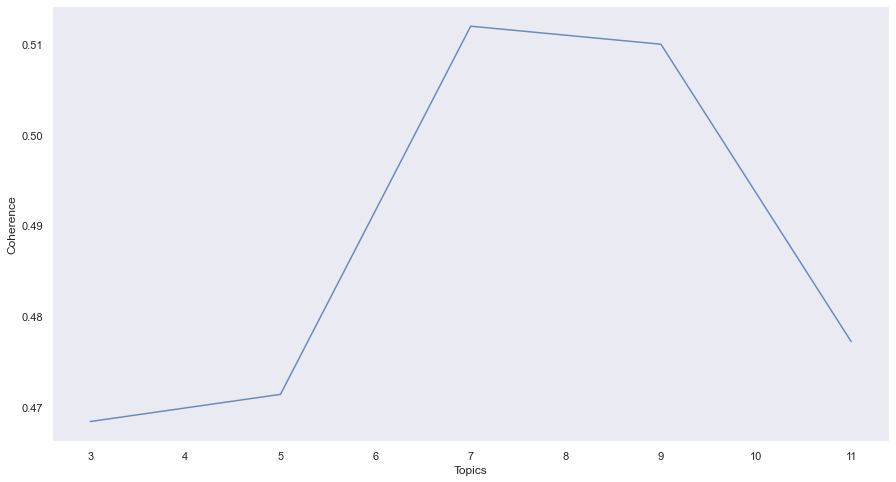

In [481]:
plt.figure(figsize=(15,8))
sns.lineplot(df_grid_res_1.Topics, df_grid_res_1.Coherence, alpha=0.8)
plt.grid()
plt.show()

In [482]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=1,
                                           alpha=0.61,
                                           eta=0.91,
                                           workers=CORES-1)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tok, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.733200021542482

Coherence Score:  0.5150321188361444


In [483]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.123767 -0.003378       1        1  22.906950
0     -0.031940 -0.154077       2        1  17.371575
5      0.165640 -0.022457       3        1  13.812984
6     -0.051862  0.096560       4        1  13.770415
1     -0.014054  0.038078       5        1  11.030041
4      0.062688  0.060915       6        1  10.666809
3     -0.006705 -0.015641       7        1  10.441225, topic_info=            Term         Freq         Total Category  logprob  loglift
663  ассортимент  7476.000000   7476.000000  Default  30.0000  30.0000
203     персонал  8753.000000   8753.000000  Default  29.0000  29.0000
25        кассир  7074.000000   7074.000000  Default  28.0000  28.0000
214      большой  7354.000000   7354.000000  Default  27.0000  27.0000
29     маленький  5481.000000   5481.000000  Default  26.0000  26.0000
..           ...          ...           ...      ...      ...      ...
225    сотрудник   460.940712   4496.834496   Topic7  -5.9624  -0.0185
215       данный   391.856468   2338.338191   Topic7  -6.1248   0.4731
24         касса   460.392466  12469.126618   Topic7  -5.9636  -1.0395
45         товар   422.183524  15561.735447   Topic7  -6.0502  -1.3477
383       другой   394.655407   8443.872477   Topic7  -6.1176  -0.8038

[555 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8142      1  0.902892  автомат
8142      2  0.016220  автомат
8142      3  0.016220  автомат
8142      4  0.016220  автомат
8142      5  0.016220  автомат
...     ...       ...      ...
47        3  0.004454     язык
47        4  0.936839     язык
47        5  0.008908     язык
47        6  0.007423     язык
47        7  0.016332     язык

[3059 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 7, 2, 5, 4])

In [484]:
pprint(lda_model.print_topics())

[(0,
  '0.011*"продукт" + 0.009*"свежий" + 0.008*"купить" + 0.007*"хороший" + '
  '0.007*"мясо" + 0.006*"цена" + 0.006*"товар" + 0.006*"такой" + 0.006*"отдел" '
  '+ 0.006*"тухлый"'),
 (1,
  '0.025*"товар" + 0.022*"кассир" + 0.015*"цена" + 0.012*"очередь" + '
  '0.012*"касса" + 0.010*"постоянно" + 0.010*"который" + 0.010*"ценник" + '
  '0.006*"другой" + 0.005*"вечный"'),
 (2,
  '0.013*"товар" + 0.008*"касса" + 0.007*"такой" + 0.006*"который" + '
  '0.005*"другой" + 0.005*"свой" + 0.005*"ценник" + 0.005*"лента" + '
  '0.005*"сказать" + 0.004*"человек"'),
 (3,
  '0.009*"очень" + 0.008*"хороший" + 0.007*"цена" + 0.007*"рынок" + '
  '0.006*"такой" + 0.006*"зайти" + 0.006*"неприятный" + 0.006*"продукт" + '
  '0.006*"самый" + 0.005*"продавец"'),
 (4,
  '0.016*"очень" + 0.016*"касса" + 0.013*"грязный" + 0.011*"грязно" + '
  '0.011*"продукт" + 0.010*"плохой" + 0.008*"другой" + 0.008*"постоянный" + '
  '0.007*"товар" + 0.007*"узкий"'),
 (5,
  '0.028*"ассортимент" + 0.020*"большой" + 0.018*"цена

In [349]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)